In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

 # for subsampling the data
from random import sample

# for plotting on a geographic map
import folium 
from folium import plugins 
import mplleaflet

Load the cleaned data set prepared in the notebook [data_preparation.ipynb](http://nbviewer.jupyter.org/github/jdoepfert/nyc_taxi_tips/blob/master/data_preparation.ipynb):

In [2]:
df = pd.read_pickle('df.pickle')

# Exploring the taxi data

### 1) From where do people take a taxi?

In [29]:
subdf = df.loc[sample(df.index, 10000)] # subsample df 
data = subdf[['pickup_latitude', 'pickup_longitude']].values

f = folium.element.Figure(width='500px',height='400x')
folium_map = folium.Map([40.7, -73.9], zoom_start=11, tiles='stamentoner') # create heatmap
folium_map.add_children(plugins.HeatMap(data, min_opacity=0.005, max_zoom=18,
                                        max_val=0.01, radius=3, blur=3))
f.add_children(folium_map)
f

The heatmap suggests that taxis are mostly used within cenral NY. Furthermore, the map shows a high pickup intensity around the two airports La Guardia and JFK.

### 2) Some histograms

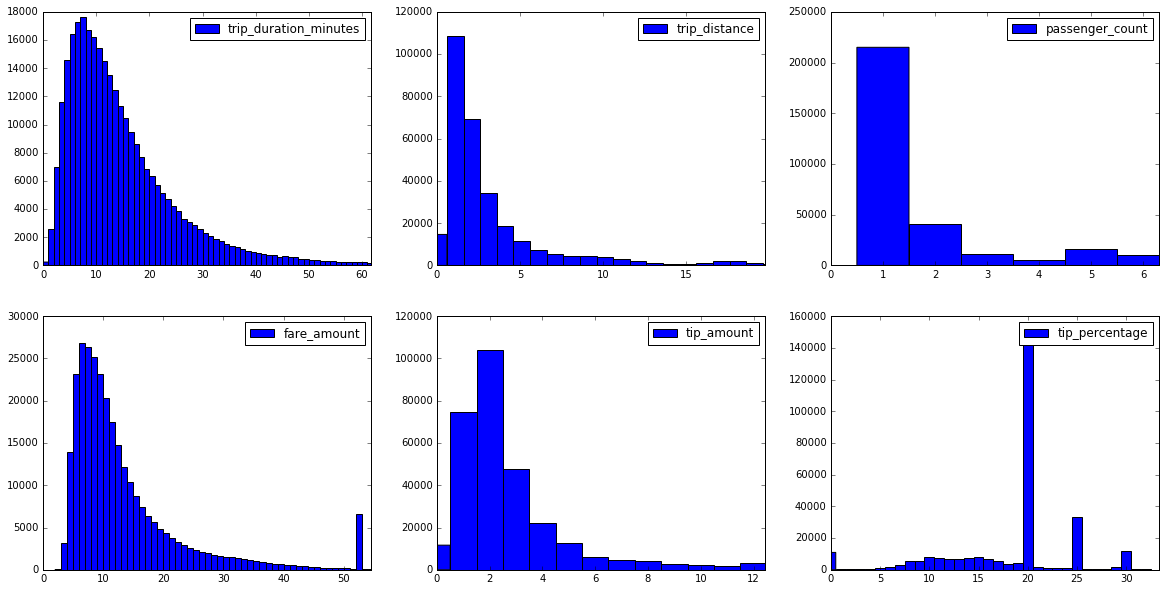

In [30]:
col_names = ['trip_duration_minutes', 'trip_distance', 'passenger_count', 'fare_amount', 'tip_amount', 'tip_percentage']
plt.subplots(figsize=(20, 10))
for index, col_name in enumerate(col_names):
    plt.subplot(2, 3, index+1)
    data = df.loc[sample(df.index, 300000)][col_name].values
    plt.hist(data, np.arange(min(data)-0.5, max(data)+1.5)) # ensure a bin size of one unit
    plt.gca().set_xlim([0, np.percentile(data, 99)*1.05])
    plt.legend([col_name])

Two things stick out here:
- There is a peak at around 52 USD in the fare amount histogram. This could corresponds to some fixed fare, maye for trips from some airport to the city center
- The tip percentage shows a prominent peak at 20%. Probably that's the widely accepted standard for taxi tips in NYC. There are three more peaks at 25%, 30% and 0%

### 3) Having a closer look at the tips
The following plot displays tip percentage versus the total fare amount:
<a id='tip_fare'></a>

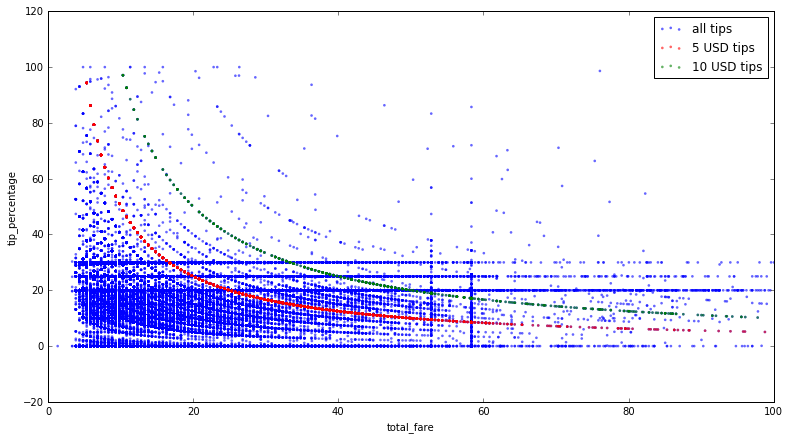

In [114]:
subdf = df.loc[sample(df.index, 300000)]
ax = subdf.plot(y='tip_percentage', x='total_fare', kind='scatter', figsize=(13,7), alpha=0.6, edgecolor='none', s=7, label='all tips')
subdf.loc[subdf.tip_amount == 5].plot(y='tip_percentage', x='total_fare', kind='scatter', ax=ax, alpha=0.6, edgecolor='none', s=7, c='r', label='5 USD tips');
subdf.loc[subdf.tip_amount == 10].plot(y='tip_percentage', x='total_fare', kind='scatter', ax=ax, alpha=0.6, edgecolor='none', s=7, c='g', label='10 USD tips');
ax.set_xlim([0,100]);

A couple of interesting things are revealed, for example:
- People prefer to tip in whole numbers, like 5 or 10 USD
- People often tip 20%, 25% or 30%, or nothing, as already seen in the histograms above
- The peak at a fixed fare of around around 52 USD seen in the histograms above appears here again, but split up into two regions (probably because of extra surcharges such as overnight charges

#### Tip dependence on day and time
Next, let's have a look at the tip percentage and the numbere of trips depending on day and time:

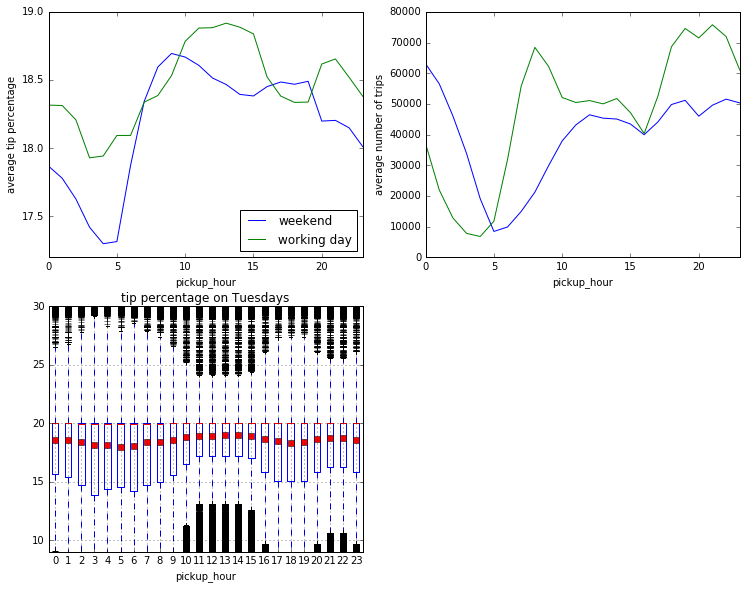

In [307]:
plt.figure(figsize=(12,10))
ax = plt.subplot(2, 2, 1)
df[df.pickup_weekday.isin([5, 6])].groupby('pickup_hour').mean().plot(y='tip_percentage', label='weekend', ax=ax)
df[~df.pickup_weekday.isin([5, 6])].groupby('pickup_hour').mean().plot(y='tip_percentage', label='working day', ax=ax)
ax.set_ylabel('average tip percentage')

ax = plt.subplot(2, 2, 2)
(df[df.pickup_weekday.isin([5, 6])].groupby('pickup_hour').size()/2).plot(label='weekend', ax=ax)
(df[~df.pickup_weekday.isin([5, 6])].groupby('pickup_hour').size()/5).plot(label='working day', ax=ax)
ax.set_ylabel('average number of trips');

ax = plt.subplot(2, 2, 3)
df[df.pickup_weekday == 1].boxplot('tip_percentage', by='pickup_hour', showmeans=True, ax=ax)
ax.set_ylim([9,30])
ax.set_title('tip percentage on Tuesdays');

plt.suptitle(""); # remove the figure title that is generated by the boxplot command

These plots indicate a dependence of the tip percentage on weekday and time. However, there is a huge variance in the data, as seen in the boxplot showing the tip percentage by hour for an example day (Monday).


#### Tip dependence on location
To get a first hint of whether the tip percentage is dependend on the pickup location, I let's display the average tip percentage within some local clusters on a map. One could e.g. use the boroughs of NY to generate such clusters. Here, will use a quick solution and create the clusters using the k-means algorithm to cluster the pickup locations into 50 clusters:

In [120]:
from sklearn.cluster import MiniBatchKMeans

X = df[['pickup_longitude','pickup_latitude']]
mbk = MiniBatchKMeans(n_clusters=50, random_state=3, batch_size=1000, 
                      max_iter = 500, verbose=0).fit(X)

df['cluster_id'] = mbk.predict(X)

Let's have a look at the clusters found by the algorithm:
<a id='kmeans'></a>

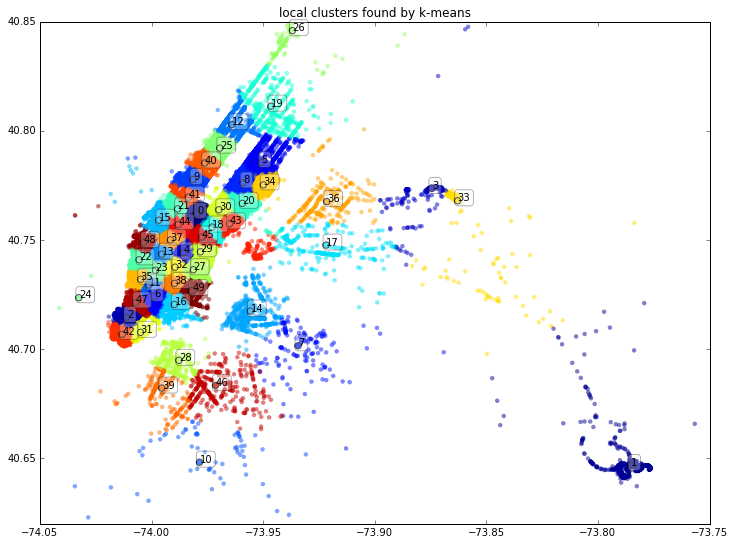

In [154]:
subidx = sample(X.index, 100000)

fig, ax = plt.subplots(figsize=(12, 9))
plt.scatter(df.loc[subidx, 'pickup_longitude'], df.loc[subidx, 'pickup_latitude'], c=df.loc[subidx,'cluster_id'], alpha=0.5, s=20, edgecolor='none')
ax.set_xlim([-74.05, -73.75])
ax.set_ylim([40.62, 40.85])

# plot cluster centroids
plt.scatter(mbk.cluster_centers_[:,0], mbk.cluster_centers_[:,1], c=mbk.predict(mbk.cluster_centers_), s=40)
for i, txt in enumerate(mbk.predict(mbk.cluster_centers_)):
    ax.annotate(txt, (mbk.cluster_centers_[:,0][i],mbk.cluster_centers_[:,1][i]), bbox=dict(boxstyle="round", fc="1", alpha=0.3))

ax.set_title('local clusters found by k-means');

We have seen before that the tip percentage varied with time and day of the week. Let's now check if it also varies with location. Therefore, I chose a fixed day and time interval (Tuesday between 7 and 9 a.m.) and plot the average tip percentage in that interval within the clusters:

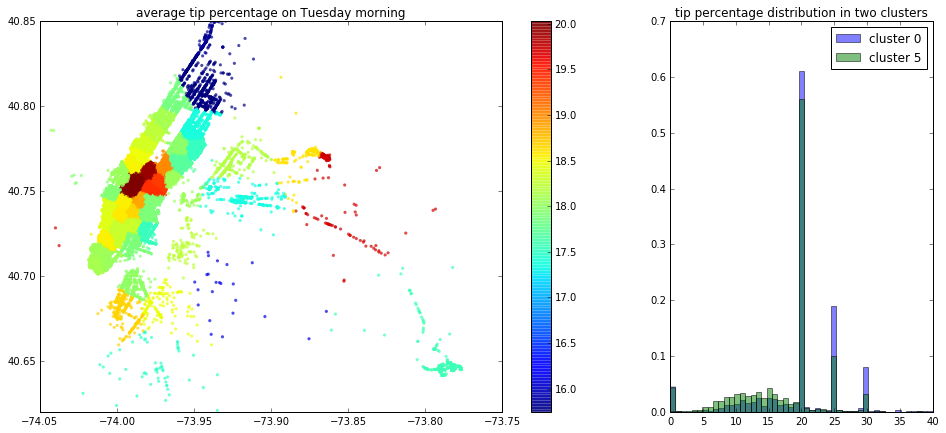

In [254]:
tuesday_morning = (df.pickup_weekday == 1) & (df.pickup_hour >= 7) & (df.pickup_hour <= 9)

cluster_means_centroids = df[tuesday_morning].groupby('cluster_id').tip_percentage.mean()

subidx = sample(df[tuesday_morning].index, 100000)
cluster_means = df.loc[subidx].join(cluster_means_centroids , on='cluster_id', rsuffix='_cluster_means').tip_percentage_cluster_means

fig = plt.figure(figsize=(16, 7))
ax = plt.subplot(1,3,(1,2))
plt.scatter(df.loc[subidx, 'pickup_longitude'], df.loc[subidx, 'pickup_latitude'], c=cluster_means, alpha=0.7, s=10, edgecolor='none')
ax.set_xlim([-74.05, -73.75])
ax.set_ylim([40.62, 40.85])
plt.title('average tip percentage on Tuesday morning')
plt.colorbar()

ax = plt.subplot(1,3,3)
bins = np.linspace(0, 40, 50)
plt.hist(df[monday_morning & (df.cluster_id==0)].tip_percentage.values, alpha=0.5, label='cluster 0', bins=bins, normed=True)
plt.hist(df[monday_morning & (df.cluster_id==5)].tip_percentage.values, alpha=0.5, label='cluster 5', bins=bins, normed=True)
plt.legend(loc='upper right')
plt.title('tip percentage distribution in two clusters');

This plot on the right hand side suggests that, on average, taxi drivers picking up people from e.g. the southern end of Central Park (cluster 0) obtain more tips on average than drivers starting from e.g. East Harlem (cluster 5).

Note however that 
- the regions are selected arbitrarily by k-means, and do not represent regions with a smilar average tip
- there is no proof that the observed differences in the average tip percentage are generally valid, especially when considering the large amount of spread in the data (see histogram on the left hand side)

Let's address those two points in the next section, where I fit a regression model to the tip percentage and validate it on a test set.

# Modeling the tip percentage
The of this final section is to find out if there are regions in NYC where taxi drivers should preferably be picking up people in order to maximize the tips. The exploratory analysis in the previous section already suggested that there are other factors next to location influcencing the tip percentage, namely time and weekday. Let's now run a random forest model on the data and see which factors it thinks are important.

### 1) A quick look at feature importances

In [201]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import  RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import utils

In [216]:
rf = RandomForestRegressor(verbose=0, n_jobs=4, n_estimators=10, max_depth=None, min_samples_leaf=400)

In [217]:
features = ['pickup_hour', 'pickup_weekday', 'pickup_latitude', 'pickup_longitude','passenger_count', 'trip_distance', 'RateCodeID', 'trip_duration_minutes']
target = 'tip_percentage'

subidx = sample(df.index, 1000000) # train with a subset of 1 000 000 samples only
subdf = df.loc[subidx]

rf.fit(subdf[features],subdf[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=400,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

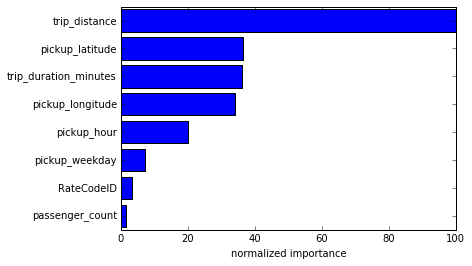

In [218]:
utils.PlotFeatureImportance(rf, features, thresh=0)

Trip distance and trip duration (which are correlated) seem to be quite important, as well as pickup location and hour. RateCodeID and passenger count seem to have least importance in determining the tip percentage. 

### 2) Random forest regression on tip percentage
The feature importance plot from above suggests that trip distance is an important feature for determining the tip. However, a taxi driver will in general not know the length of a trip in advance. Therefore I will consider only location, time and weekday here.

To make the problem tractable for my low-budget laptop, I will simplify the problem to Tuesday mornings here:

In [245]:
tuesday_morning = (df.pickup_weekday == 1) & (df.pickup_hour >= 7) & (df.pickup_hour <= 9)
subdf = df[tuesday_morning]
subdf.shape

(215178, 25)

This not only decreases the size of the data set, but also eliminates time and weekeday from the list of features, so that we are basically left only with pickup location.

To be able to validate the results from the model, I will split the data set in to training and test sets.

In [246]:
features = ['pickup_latitude', 'pickup_longitude']
X_train, X_test, y_train, y_test = train_test_split(subdf[features], subdf[target], test_size = 0.3, random_state=5)

Let's train the random forest:

In [247]:
rf = RandomForestRegressor(verbose=0, n_jobs=4, n_estimators=15, max_depth=None, min_samples_leaf=400)

In [251]:
rf.fit(X_train, y_train);

Now plot the predictions of the model on the training set:

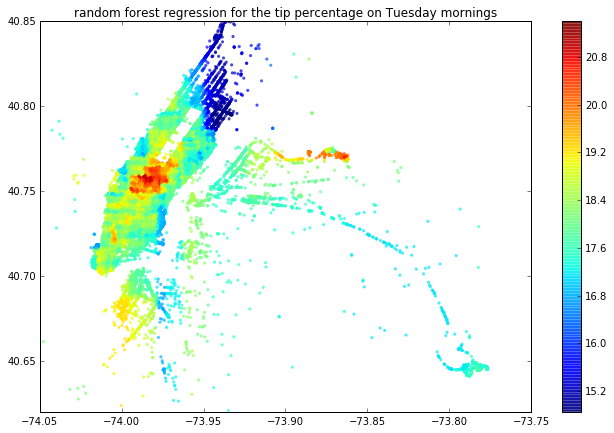

In [253]:
train_predicted  = rf.predict(X_train)
fig, ax = plt.subplots(figsize=(11, 7))
plt.scatter(X_train['pickup_longitude'], X_train['pickup_latitude'], c=train_predicted , alpha=0.7, s=10, edgecolor='none')
ax.set_xlim([-74.05, -73.75])
ax.set_ylim([40.62, 40.85])
plt.title('random forest regression for the tip percentage on Tuesday mornings')
plt.colorbar();

This looks quite similar to the plot showing the average tip percentage within the clusters found by k-means, which is a good sign. Note however the random forest model shows more meaningful "clusters", since they are calculated based on the tip data. In contrast, the clusters generated by k-means are purely based on location data, so they do not neccessarily represent regions of similar tip percentage.

Let's now validate the performance of our model on the test set:

In [286]:
test_predicted = rf.predict(X_test)
train_predicted  = rf.predict(X_train)
print("MSE random forest: test/train: %.2f/%.2f" % (mean_squared_error(y_test, test_predicted),
                                                   mean_squared_error(y_train, train_predicted)))

MSE random forest: test/train: 43.45/42.61


The test error is only slightly higher than the training error, indicating that our random forest model does not overfit.

*Side note*: The model predicts a lower tip percentage for trips starting at JFK airport, compared to trips starting from La Guardia. An explanation for this could be the longer way from JFK to the city center: The relative tip amount decreases with increasing trip distance, compare [this plot from above](#tip_fare). However, a driver might still prefer JFK, since he spends more time driving (and earning money) and less time doing other stuff like collecting money from the passengers, and looking for new passengers. Hence, to recommend the best pickup location to a taxi driver, a metric taking into account those fixed costs for each taxi trip might me more appropriate than the simple tip percentage.

### 4) Model evaluation

Is the random forest regression model any good? To answer this question, let's compare it to a very simple "model", that just predicts the overall mean tip percentage for each trip:

In [284]:
print("MSE sample mean: test/train: %.2f/%.2f" % (mean_squared_error(y_train.mean()*np.ones(test_predicted.shape), y_test),mean_squared_error(y_train.mean()*np.ones(train_predicted.shape), y_train)))

MSE sample mean: test/train: 44.26/43.85


The test error of this "mean model" is 44.3, which is only slightly higher than the 43.5 achieved by the random forest model. Does this mean our model is almost useless? Not neccessarily, it could also mean that the vast majority of the taxi trips start from locatations with similar average tip percentage, so that the "mean model" gives good results.

 A look at the test set residuals of the random forest model might give further insights:

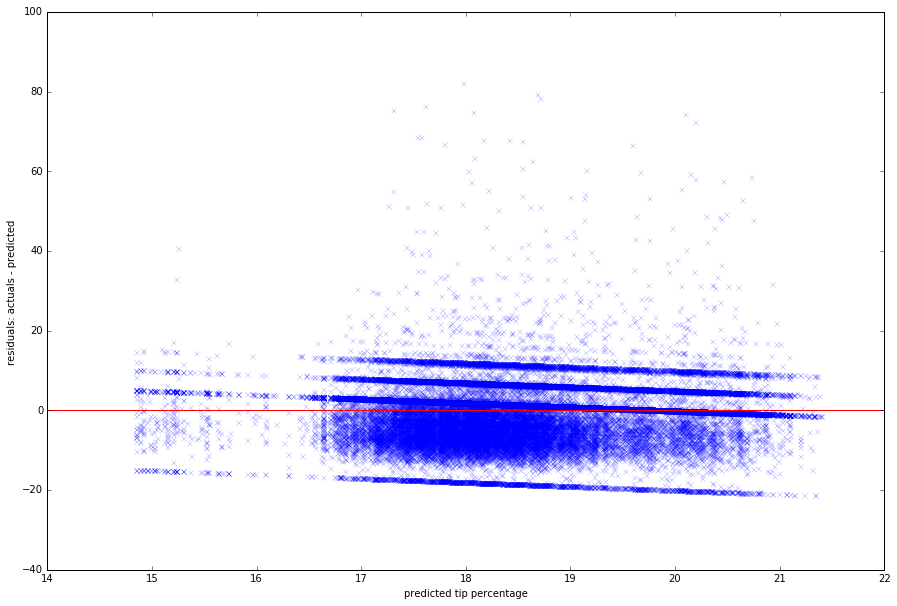

In [283]:
plt.figure(figsize=(15,10))
plt.plot(test_predicted, y_test - test_predicted , 'x', alpha=0.3, markersize=5)
plt.plot([14,22],[0,0],'r-');
plt.gca().set_xlabel('predicted tip percentage')
plt.gca().set_ylabel('residuals: actuals - predicted ');

The spread of the residuals around zero is quite large, which indicates that predicting the tip accurately is quite hard. Note however that the model seems to do something right: when it predicts tips below 17%, there are hardly any "extreme" tips above 35%, whereas there is a significant amount of those "extreme" tips at predictions higher than 17%.

Let's do another quick evaluation: I compare the predictions of the model actual test data in clusters 0 and 5 (see [this plot](#kmeans)).

In [306]:
pd.DataFrame({'cluster 0 (below Central Park)':[y_test[df.loc[X_test.index].cluster_id == 0].mean(),
                                                rf.predict(X_test[df.loc[X_test.index].cluster_id == 0]).mean()],
              'cluster 5 (East Harlem)':[y_test[df.loc[X_test.index].cluster_id == 5].mean(),
                                         rf.predict(X_test[df.loc[X_test.index].cluster_id == 5]).mean()]}, 
              index=['true average tip percentage', 'predicted average tip percentage'])

,cluster 0 (below Central Park),cluster 5 (East Harlem)
true average tip percentage,20.081454,17.344133
predicted average tip percentage,20.016645,17.485385


This suggests the conclusion that the random forest model actually does a good job in predicting the mean tip percentage depending on location, as far as it is possible to do such a prediction with the given factors. 

# Concluding remarks

- The analysis performed here is biased: Only credit card tips are available in the data set. Including cash tips might change the results
- To yield a more trustworthy validation of the models, the train-test-split should be done differently: The test set should only contain samples from days that were not present in the training set
- I only looked at data from June 2015. The analysis of more data could give rise to better results
- For the sake of simplicity, I only looked at a fixed time frame on a fixed day for this analysis. Fitting a regression model to all the available parameters (time, day etc.) should be considered
- I did not include any external data sources that might influence tiping behaviour, such as holidays, weather etc.
- As discussed in a side note above, another metric including fixed costs of picking up a person might be more valuable for taxi drivers compared to plain tip percentage
- One could consider using a classification model predicting tip categories instead of a regression model
